# Quantum Imaginary Time Evolution

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

from scipy.linalg import lstsq
from scipy.linalg import eigh

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom
from qiskit.tools import parallel_map

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Testing operator construction

### Graycode

In [2]:
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)

## Get list of sigmas (all pauli terms with odd number Y gates)
n_qubits=H_qubit.N_qubits

## vector of WeightedPauliOperators representing vector Sigma
sigmas=sigma_terms(n_qubits)

## Construct b
b_pauli_terms=b_terms(H_qubit,sigmas)
# for bI in b_pauli_terms:
#     print(bI)
      
## Construct S
S_pauli_terms=S_terms(sigmas)

## Get commuting set of all operators which must be computed
pauli_set=get_intersection_pauli_terms(H_qubit,b_pauli_terms,S_pauli_terms)
commuting_sets=get_commuting_sets(sorted(pauli_set))
for p in commuting_sets:
    print(p, commuting_sets[p])


XX ['II', 'IX', 'XI', 'XX']
XY ['IY', 'XY']
XZ ['IZ', 'XZ']
YX ['YI', 'YX']
YY ['YY']
YZ ['YZ']
ZX ['ZI', 'ZX']
ZY ['ZY']
ZZ ['ZZ']


### Jordan Wigner

In [3]:
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = JordanWignerHamiltonian(H)

## Get list of sigmas (all pauli terms with odd number Y gates)
n_qubits=H_qubit.N_qubits

## vector of WeightedPauliOperators representing vector Sigma
sigmas=sigma_terms(n_qubits,encoding="jordan_wigner")
# for sigma in sigmas:
#     print(sigma.print_details())
## Construct b
b_pauli_terms=b_terms(H_qubit,sigmas)
# for bI in b_pauli_terms:
#     print(bI)
      
## Construct S
S_pauli_terms=S_terms(sigmas)

## Get commuting set of all operators which must be computed
pauli_set=get_intersection_pauli_terms(H_qubit,b_pauli_terms,S_pauli_terms)
commuting_sets=get_commuting_sets(sorted(pauli_set))
print(f"Num commuting sets: {len(commuting_sets)}")
for p in commuting_sets:
    print(p, commuting_sets[p])

Num commuting sets: 18
ZZZ ['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ']
XXX ['IXX', 'XIX', 'XXI']
XXY ['IXY', 'XIY']
XYX ['IYX', 'XYI']
YYY ['IYY', 'YIY', 'YYI']
XXZ ['XXZ']
XYZ ['XYZ']
XZX ['XZX']
XZY ['XZY']
YXX ['YIX', 'YXI']
YXZ ['YXZ']
YYZ ['YYZ']
YZX ['YZX']
YZY ['YZY']
ZXX ['ZXX']
ZXY ['ZXY']
ZYX ['ZYX']
ZYY ['ZYY']


# Quantum imaginary time evolution

## Graycode $N_\mathrm{max}=4$

In [4]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'qasm_simulator',
    'N_trials' : 1,
    'N_time_steps': 30,
    'delta_time' : 0.01,
    'merge_step' : None,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'device_name' : None,
    'mitigate_meas_error' : False,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'layout' : None
    }

parameters=set_qite_parameters(parameters,verbose=True)

No value for parameter qlanczos provided.
Setting qlanczos to default value False.
No value for parameter krylov_threshold provided.
Setting krylov_threshold to default value 0.99.
No value for parameter qite_threshold provided.
Setting qite_threshold to default value 0.01.
No value for parameter qlanczos_threshold provided.
Setting qlanczos_threshold to default value 0.01.
No value for parameter show_progress provided.
Setting show_progress to default value True.
No value for parameter number_cnot_pairs provided.
Setting number_cnot_pairs to default value 0.
No value for parameter number_circuit_folds provided.
Setting number_circuit_folds to default value 0.
No value for parameter zero_noise_extrapolation provided.
Setting zero_noise_extrapolation to default value False.

Experiment parameters
{'N_cpus': 1,
 'N_shots': 10000,
 'N_time_steps': 30,
 'N_trials': 1,
 'Nmax': 4,
 'Qite_threshold': 0.01,
 'backend': 'qasm_simulator',
 'delta_time': 0.01,
 'device_name': None,
 'encoding': 

In [4]:
backend = 'statevector_simulator'
parameters['backend']='statevector_simulator'
parameters['qite_threshold']=1e-10
parameters['Nmax']=4

H = hamiltonian_matrix(Nmax=parameters['Nmax'], J=1, interaction=parameters['interaction'])
H_qubit = GrayCodeHamiltonian(H)

sv_energies_30 =qite_experiment(H_qubit,parameters)

100%|██████████| 30/30 [00:02<00:00, 10.46it/s]


In [5]:
parameters['backend']='qasm_simulator'
Energy_table=[]
for threshold in [1e-1,1e-2,1e-5,1e-10]:
    parameters['qite_threshold']=threshold
    Energies=qite_experiment(H_qubit,parameters)
    Energy_table.append(Energies)

100%|██████████| 30/30 [00:16<00:00,  1.80it/s]


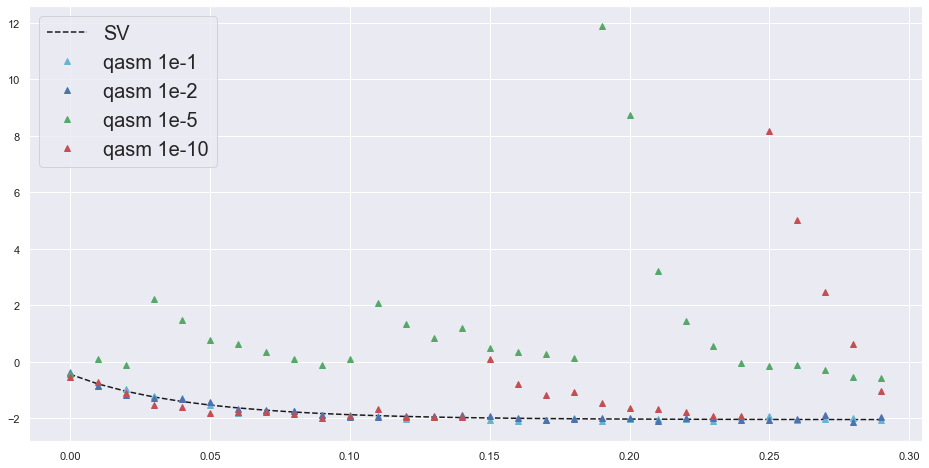

In [6]:
time=[parameters["delta_time"]*t for t in range(parameters["N_time_steps"])]
plt.plot(time,sv_energies_30,'k--',label="SV")
plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.legend(prop={'size': 20})

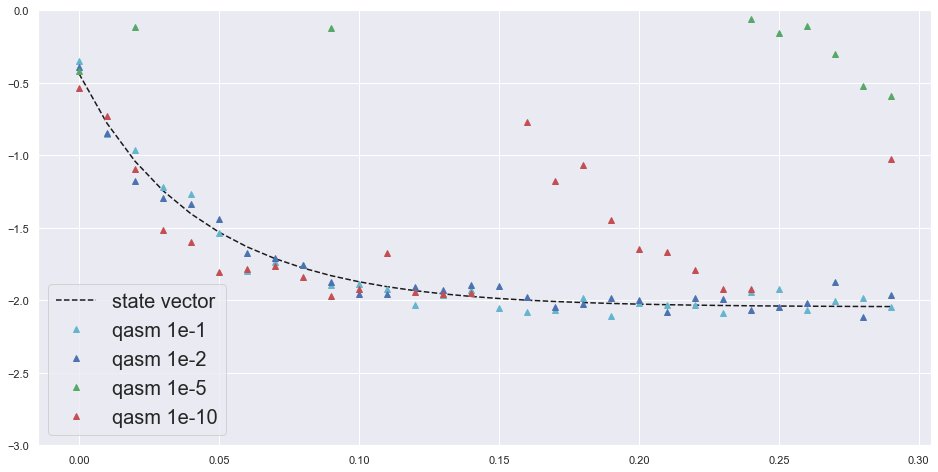

In [7]:
time=[parameters["delta_time"]*t for t in range(parameters["N_time_steps"])]
plt.plot(time,sv_energies_30,'k--',label="state vector")
plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.ylim(-3,0)
plt.legend(prop={'size': 20})

Testing different time steps.  Approximation of normalization coefficient requires $\Delta t\le0.1$ 

In [10]:
## setting parameters
parameters['qite_threshold']=1e-2

H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)

Energy_table_time_sv=[]
Energy_table_time_qasm=[]

for delta_time in [0.001,0.01,0.05]:
    parameters['delta_time']=delta_time
    
    parameters['backend']='qasm_simulator'
    Energy_table_time_qasm.append(qite_experiment(H_qubit,parameters))

    parameters['backend']='statevector_simulator'
    Energy_table_time_sv.append(qite_experiment(H_qubit,parameters))


100%|██████████| 30/30 [00:02<00:00, 10.12it/s]


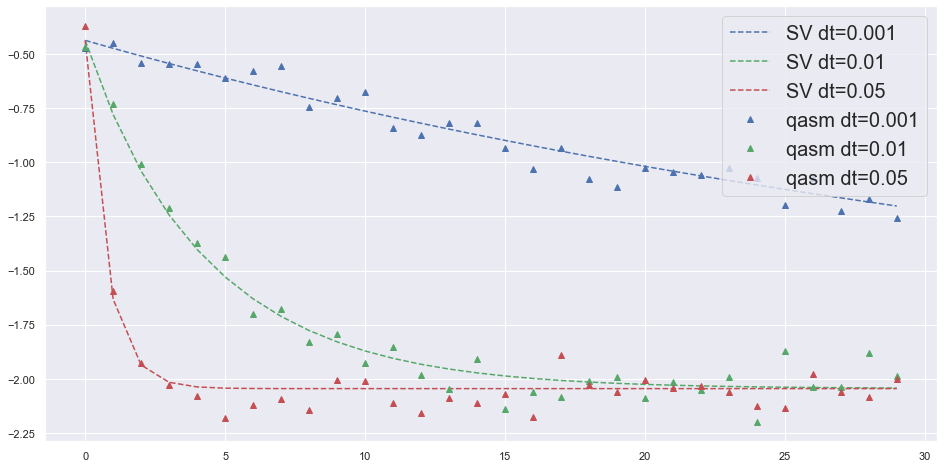

In [11]:
time=[t for t in range(parameters["N_time_steps"])]
plt.plot(time,Energy_table_time_sv[0],'b--',label="SV dt=0.001")
plt.plot(time,Energy_table_time_sv[1],'g--',label="SV dt=0.01")
plt.plot(time,Energy_table_time_sv[2],'r--',label="SV dt=0.05")

plt.plot(time,Energy_table_time_qasm[0],'b^',label="qasm dt=0.001")
plt.plot(time,Energy_table_time_qasm[1],'g^',label="qasm dt=0.01")
plt.plot(time,Energy_table_time_qasm[2],'r^',label="qasm dt=0.05")
plt.legend(prop={'size': 20})

Testing merge $\{A+i\}$ into single operators after different number of iterations.

In [17]:
parameters['backend']='statevector_simulator'
parameters['delta_time']=0.01
parameters['qite_threshold']=1e-2

H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)

merge_iterations=[None,1,10]
Energy_table_step=[]
for merge_step in merge_iterations:
    parameters['merge_step']=merge_step
    Energy_table_step.append(qite_experiment(H_qubit,parameters))

100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


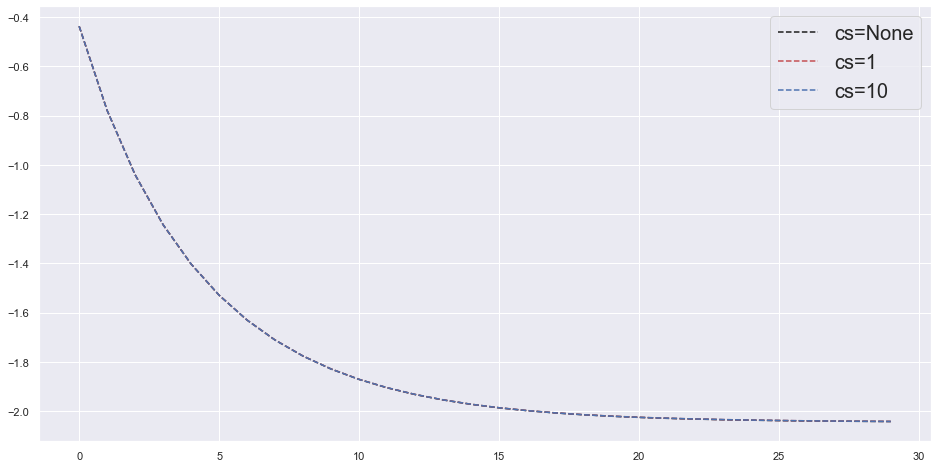

In [18]:
time=[t for t in range(parameters["N_time_steps"])]
plt.plot(time,Energy_table_step[0],'g--',label="cs=None")
plt.plot(time,Energy_table_step[1],'r--',label="cs=1")
plt.plot(time,Energy_table_step[2],'b--',label="cs=10")
plt.plot()
plt.legend(prop={'size': 20})


In [20]:
parameters['backend']='qasm_simulator'
parameters['delta_time']=0.01
parameters['qite_threshold']=1e-2

Energy_table_step_qasm=[]
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)


merge_iterations=[None,1,10]
for ms in merge_iterations:
    parameters['merge_step']=ms
    Energy_table_step_qasm.append(qite_experiment(H_qubit,parameters))

100%|██████████| 30/30 [00:07<00:00,  4.00it/s]


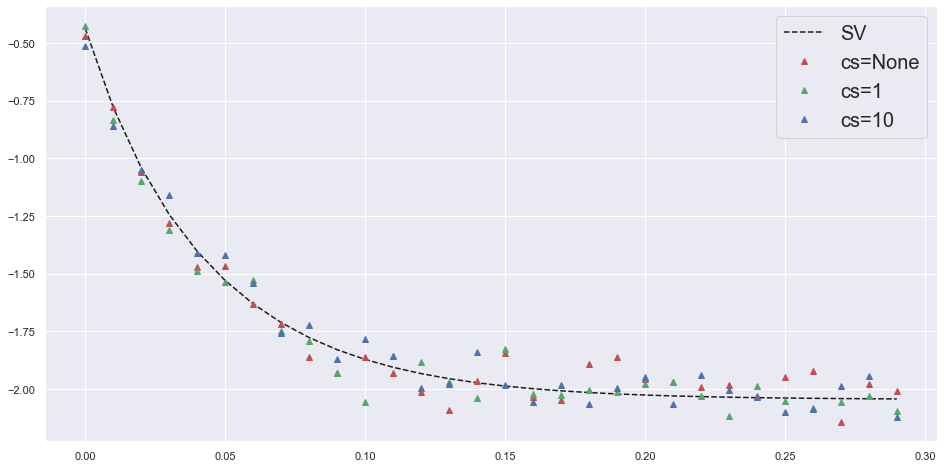

In [21]:
time=[0.01*t for t in range(parameters["N_time_steps"])]
plt.plot(time,Energy_table_step[0],'k--',label="SV")
plt.plot(time,Energy_table_step_qasm[0],'r^',label="cs=None")
plt.plot(time,Energy_table_step_qasm[1],'g^',label="cs=1")
plt.plot(time,Energy_table_step_qasm[2],'b^',label="cs=10")
plt.plot()
plt.legend(prop={'size': 20})

## Jordan Wigner Encoding $N_\mathrm{max}=4$

In [22]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'jordan_wigner',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 30,
    'delta_time' : 0.01,
    'merge_step' : None,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'device_name' : None,
    'mitigate_meas_error' : False,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'layout' : None
    }

parameters=set_qite_parameters(parameters)


No value for parameter qlanczos provided.
Setting qlanczos to default value False.
No value for parameter krylov_threshold provided.
Setting krylov_threshold to default value 0.99.
No value for parameter qite_threshold provided.
Setting qite_threshold to default value 0.01.
No value for parameter qlanczos_threshold provided.
Setting qlanczos_threshold to default value 0.01.
No value for parameter show_progress provided.
Setting show_progress to default value True.
No value for parameter number_cnot_pairs provided.
Setting number_cnot_pairs to default value 0.
No value for parameter number_circuit_folds provided.
Setting number_circuit_folds to default value 0.
No value for parameter zero_noise_extrapolation provided.
Setting zero_noise_extrapolation to default value False.

Experiment parameters
{'N_cpus': 1,
 'N_shots': 10000,
 'N_time_steps': 30,
 'N_trials': 1,
 'Nmax': 4,
 'Qite_threshold': 0.01,
 'backend': 'statevector_simulator',
 'delta_time': 0.01,
 'device_name': None,
 'enco

In [23]:
## setting parameters
parameters['qite_threshold']=1e-2
parameters['N_time_steps']=50
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = JordanWignerHamiltonian(H)

Energy_table_time_sv=[]
Energy_table_time_qasm=[]

for delta_time in [0.001,0.01,0.05]:
    parameters['delta_time']=delta_time
    
    parameters['backend']='qasm_simulator'
    Energy_table_time_qasm.append(qite_experiment(H_qubit,parameters))

    parameters['backend']='statevector_simulator'
    Energy_table_time_sv.append(qite_experiment(H_qubit,parameters))


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


Number of qubit:  3


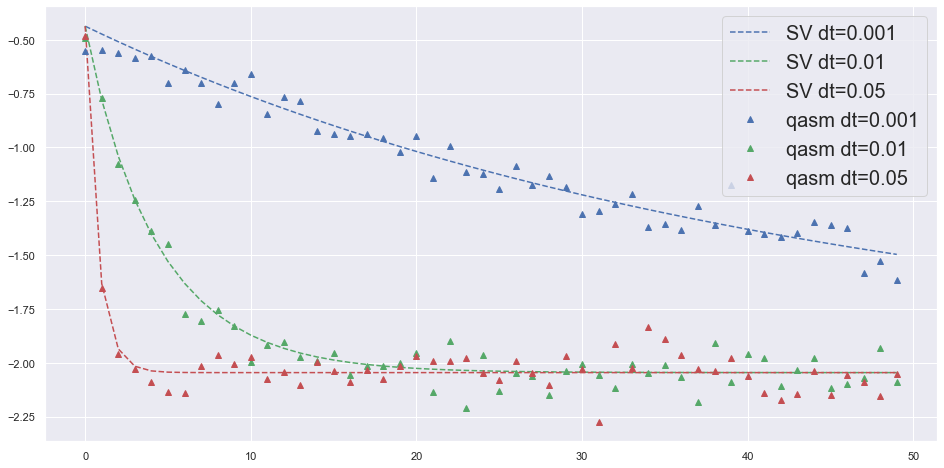

In [24]:
print("Number of qubit: ",H_qubit.N_qubits)
time=[t for t in range(parameters["N_time_steps"])]
plt.plot(time,Energy_table_time_sv[0],'b--',label="SV dt=0.001")
plt.plot(time,Energy_table_time_sv[1],'g--',label="SV dt=0.01")
plt.plot(time,Energy_table_time_sv[2],'r--',label="SV dt=0.05")

plt.plot(time,Energy_table_time_qasm[0],'b^',label="qasm dt=0.001")
plt.plot(time,Energy_table_time_qasm[1],'g^',label="qasm dt=0.01")
plt.plot(time,Energy_table_time_qasm[2],'r^',label="qasm dt=0.05")
plt.legend(prop={'size': 20})

## 3 qubits

In [6]:
parameters = {
    'Nmax' : 14,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 50,
    'delta_time' : 0.01,
    'merge_step' : None,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'device_name' : None,
    'mitigate_meas_error' : False,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'layout' : None
    }

parameters=set_qite_parameters(parameters,verbose=False)

In [7]:
# # time_steps=5
# time_steps=100
# delta_time=0.01
# verbose=False
# backend = 'statevector_simulator'
# initialization="single_state"
H = hamiltonian_matrix(
    Nmax=parameters['Nmax'],
    J=1,
    interaction=parameters['interaction']
    )
H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits
print(n_qubits)

Energy_table_step_3q=[]
merge_iterations=[None,1,2,10,25]
dummy_index=0
for merge_step in merge_iterations:
    parameters['merge_step']=merge_step
    Energy_table_step_3q.append(qite_experiment(H_qubit,parameters))

  0%|          | 0/50 [00:00<?, ?it/s]

3


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


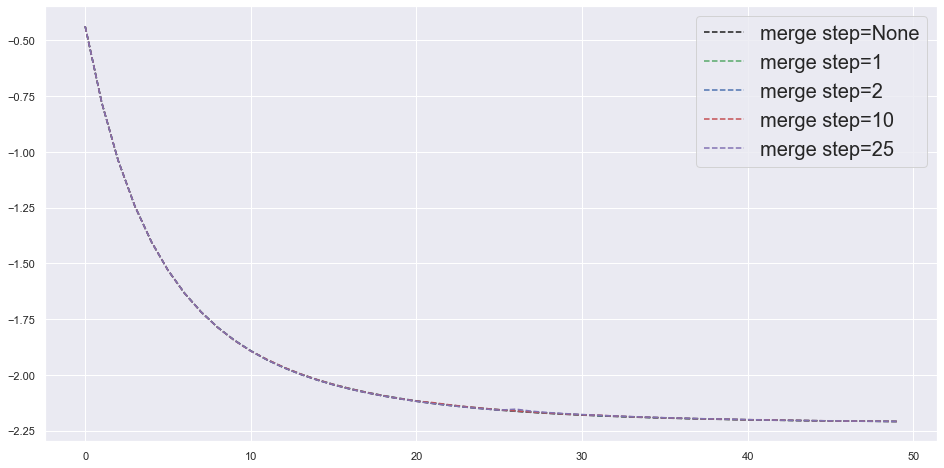

In [8]:
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,Energy_table_step_3q[0],'k--',label="merge step=None")
plt.plot(time,Energy_table_step_3q[1],'g--',label="merge step=1")
plt.plot(time,Energy_table_step_3q[2],'b--',label="merge step=2")
plt.plot(time,Energy_table_step_3q[3],'r--',label="merge step=10")
plt.plot(time,Energy_table_step_3q[4],'m--',label="merge step=25")
plt.legend(prop={'size': 20})

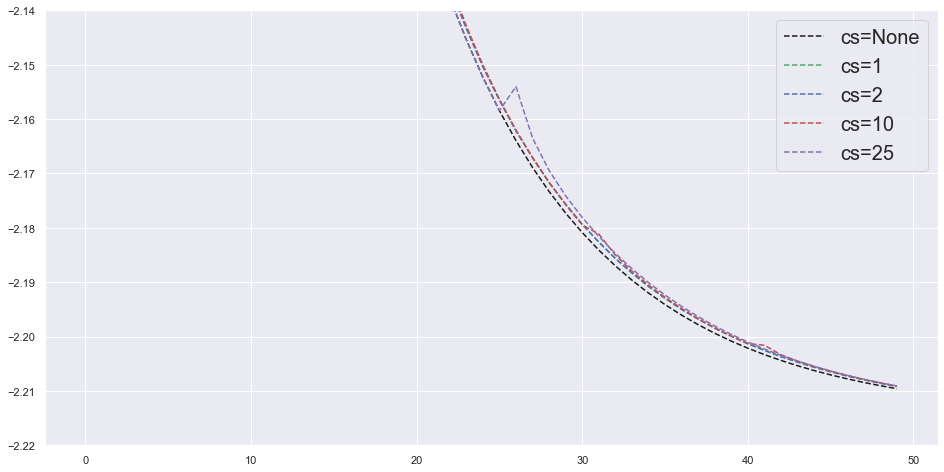

In [12]:
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,Energy_table_step_3q[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step_3q[1],'g--',label="cs=1")
plt.plot(time,Energy_table_step_3q[2],'b--',label="cs=2")
plt.plot(time,Energy_table_step_3q[3],'r--',label="cs=10")
plt.plot(time,Energy_table_step_3q[4],'m--',label="cs=25")
plt.ylim(-2.22,-2.14)
plt.legend(prop={'size': 20})

In [13]:
# time_steps=5
time_steps=100
delta_time=0.01
verbose=False
parameters['backend'] = 'qasm_simulator'

Energy_table_step_qasm_3q=[]
merge_iterations=[1,2,10]
for merge_step in merge_iterations:
    parameters['merge_step']=merge_step
    Energy_table_step_qasm_3q.append(qite_experiment(H_qubit,parameters))

100%|██████████| 50/50 [04:31<00:00,  5.42s/it]


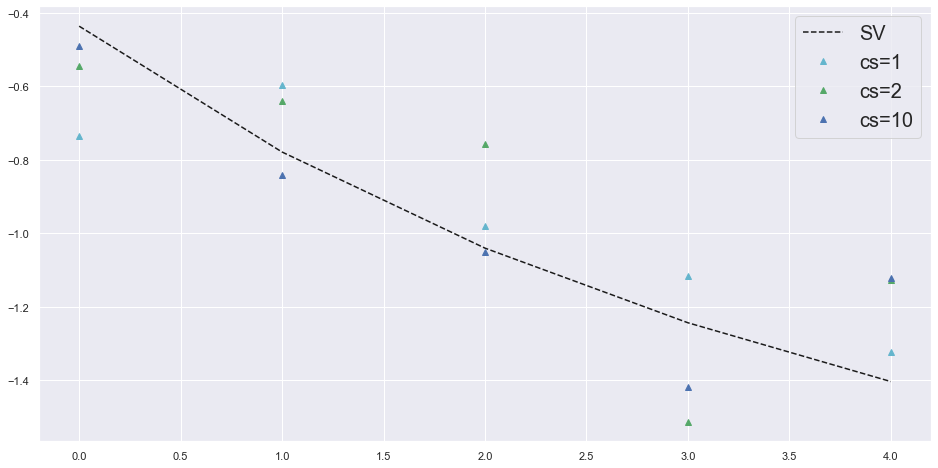

In [16]:
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,Energy_table_step_3q[0],'k--',label="SV")
plt.plot(time,Energy_table_step_qasm_3q[0],'c^',label="cs=1")
plt.plot(time,Energy_table_step_qasm_3q[1],'g^',label="cs=2")
plt.plot(time,Energy_table_step_qasm_3q[2],'b^',label="cs=10")
# plt.xlim(60,100)
# plt.ylim(-2.2151,-2.2145)
plt.legend(prop={'size': 20})

## Jordan Wigner

In [18]:
## TODO update to match new qite_experiment which takes parameter dict as input

time_steps=20
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="single_state"

qasm_energies_table_cs=[]

H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = JordanWignerHamiltonian(H)
n_qubits=H_qubit.N_qubits
# print(H_qubit.matrix)
print(eigh(H_qubit.matrix)[0])
# print(H_qubit.pauli_partitions)

Energy_table_step_2q_jw=[]
merge_iterations=[None,1,2,10]
for cs in merge_iterations:
    Energy_table_step_2q_jw.append(
        qite_experiment(
            H_qubit,time_steps,delta_time,backend,initialization,
            encoding="jordan_wigner",A_threshold=1e-10,cstep=cs)
    )

  0%|          | 0/20 [00:00<?, ?it/s]

[-2.0456709   0.          6.51591083  8.56158173 22.50183716 24.54750806
 31.06341889 33.10908979]


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


-2.045670898406403


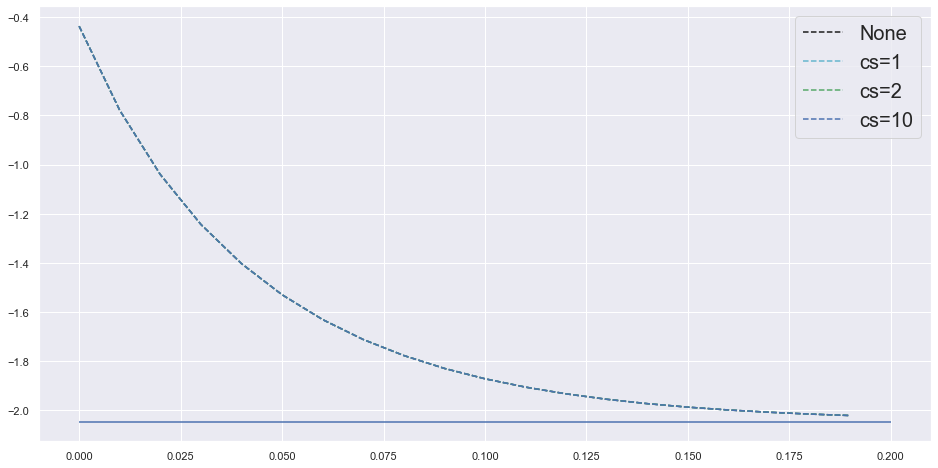

In [19]:
exact_E=eigh(H_qubit.matrix)[0][0]
print(exact_E)
time=[delta_time*t for t in range(time_steps)]
plt.plot(time,Energy_table_step_2q_jw[0],'k--',label="None")
plt.plot(time,Energy_table_step_2q_jw[1],'c--',label="cs=1")
plt.plot(time,Energy_table_step_2q_jw[2],'g--',label="cs=2")
plt.plot(time,Energy_table_step_2q_jw[3],'b--',label="cs=10")
plt.hlines(exact_E,0,delta_time*time_steps)
# plt.xlim(60,100)
# plt.ylim(-2.2151,-2.2145)
plt.legend(prop={'size': 20})

In [22]:
## Testing
N_states=4
encoding="gray_code"
N_qubits = int(np.ceil(np.log2(N_states)))

measurement_idx="X"*N_qubits
thetas = np.random.uniform(low=-np.pi/2, high=np.pi/2,size=N_states-1)

circuit=variational_circuit(encoding,thetas,measurement_idx,"qasm_simulator",num_cnot_pairs=1,num_folding=1)
# circuit.draw(output="mpl",filename="circuit.pdf")
# circuit.draw()


# CNOT extrapolation

In [4]:
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)
evolution_set=[H_qubit.weighted_pauli]
time=1
num_cnot_pairs=0


q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit=initialize_circuit(q,c)
circuit=append_evolution_circuit(q,evolution_set,time,circuit,num_cnot_pairs)
print(circuit.decompose().draw())

num_cnot_pairs=1
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit=initialize_circuit(q,c)
circuit=append_evolution_circuit(q,evolution_set,time,circuit,num_cnot_pairs)
print(circuit.decompose().draw())


                                           ┌──────────┐            »
q75_0: ──────────────■──────────────────■──┤ U2(0,pi) ├────────────»
       ┌──────────┐┌─┴─┐┌────────────┐┌─┴─┐├──────────┤┌──────────┐»
q75_1: ┤ U2(0,pi) ├┤ X ├┤ U1(7.8262) ├┤ X ├┤ U2(0,pi) ├┤ U2(0,pi) ├»
       └──────────┘└───┘└────────────┘└───┘└──────────┘└──────────┘»
c56_0: ════════════════════════════════════════════════════════════»
                                                                   »
c56_1: ════════════════════════════════════════════════════════════»
                                                                   »
«                                                           ┌──────────┐»
«q75_0: ─────────────────────────────■───────────────────■──┤ U2(0,pi) ├»
«       ┌─────────────┐┌──────────┐┌─┴─┐┌─────────────┐┌─┴─┐└──────────┘»
«q75_1: ┤ U1(-7.8262) ├┤ U2(0,pi) ├┤ X ├┤ U1(-4.2866) ├┤ X ├────────────»
«       └─────────────┘└──────────┘└───┘└─────────────┘└───┘            »
«c56_0: ═

In [12]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit=initialize_circuit(q,c)
circuit.h(q)
circuit.measure(q,c)
job=execute(circuit,
            backend=Aer.get_backend("qasm_simulator"),
            shots=100
           )
job.result().get_counts(circuit)
# job.result().to_dict()

{'10': 24, '00': 20, '01': 27, '11': 29}

In [4]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 30,
    'delta_time' : 0.01,
    'merge_step' : None,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'device_name' : None,
    'mitigate_meas_error' : False,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'layout' : None,
    'number_cnot_pairs': 0
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)      
energies_sv=qite_experiment(H_qubit,parameters)
parameters['backend']='qasm_simulator'
energies_qasm=qite_experiment(H_qubit,parameters)
parameters['number_cnot_pairs']=1
energies_cnot=qite_experiment(H_qubit,parameters)


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


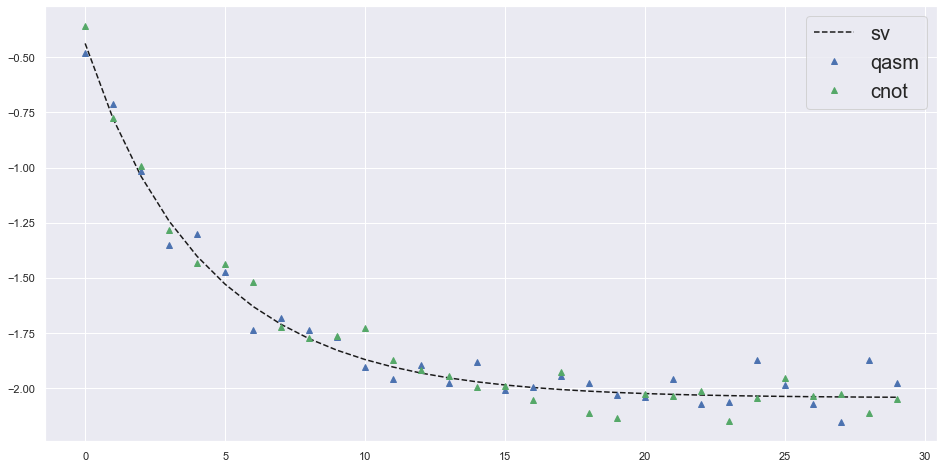

In [5]:
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,energies_sv,'k--',label="sv")
plt.plot(time,energies_qasm,'b^',label="qasm")
plt.plot(time,energies_cnot,'g^',label="cnot")
plt.legend(prop={'size': 20})

# Circuit Folding

In [6]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 30,
    'delta_time' : 0.01,
    'merge_step' : None,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'number_circuit_folds': 0
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(parameters['Nmax'],J=1,interaction=parameters["interaction"])
H_qubit = GrayCodeHamiltonian(H)      

energies_sv=qite_experiment(H_qubit,parameters)
parameters['backend']='qasm_simulator'
energies_qasm=qite_experiment(H_qubit,parameters)
parameters['number_circuit_folds']=1
energies_folded=qite_experiment(H_qubit,parameters)



100%|██████████| 30/30 [00:34<00:00,  1.15s/it]


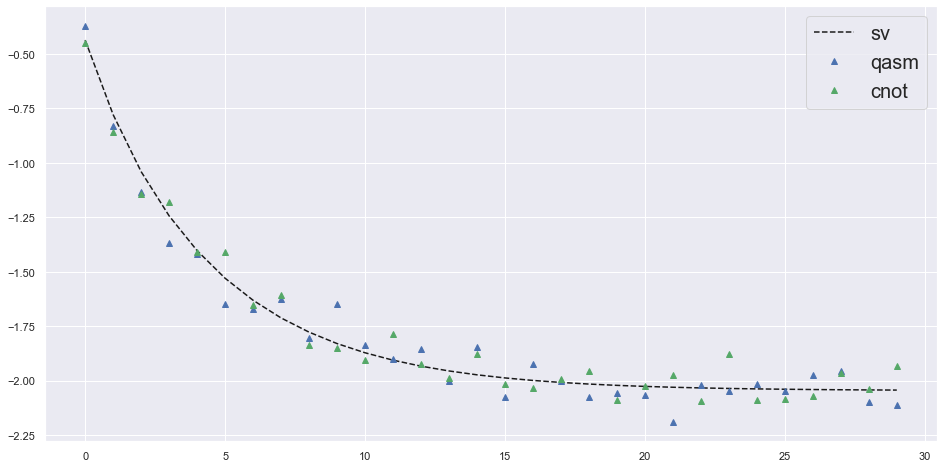

In [7]:
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,energies_sv,'k--',label="sv")
plt.plot(time,energies_qasm,'b^',label="qasm")
plt.plot(time,energies_folded,'g^',label="cnot")
plt.legend(prop={'size': 20})

# QASM with noise

In [8]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 200,
    'delta_time' : 0.01,
    'merge_step' : 1,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'device_name':'ibmq_vigo',
    'mitigate_meas_error' : True,
    'qlanczos':True
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(parameters['Nmax'],J=1,interaction=parameters["interaction"])
H_qubit = GrayCodeHamiltonian(H)      

energies_sv,coefs_sv=qite_experiment(H_qubit,parameters)

parameters['backend']='qasm_simulator'
energies_qasm,coefs_qasm=qite_experiment(H_qubit,parameters)

parameters['merge_step']=None
energies_no_merge,coefs_no_merge=qite_experiment(H_qubit,parameters)



 10%|█         | 20/200 [00:00<00:01, 96.70it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/200 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/200 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


100%|██████████| 200/200 [13:52<00:00,  4.16s/it]


[-2.0456709   8.56158173 24.54750806]


ValueError: x and y must have same first dimension, but have shapes (200,) and (50,)

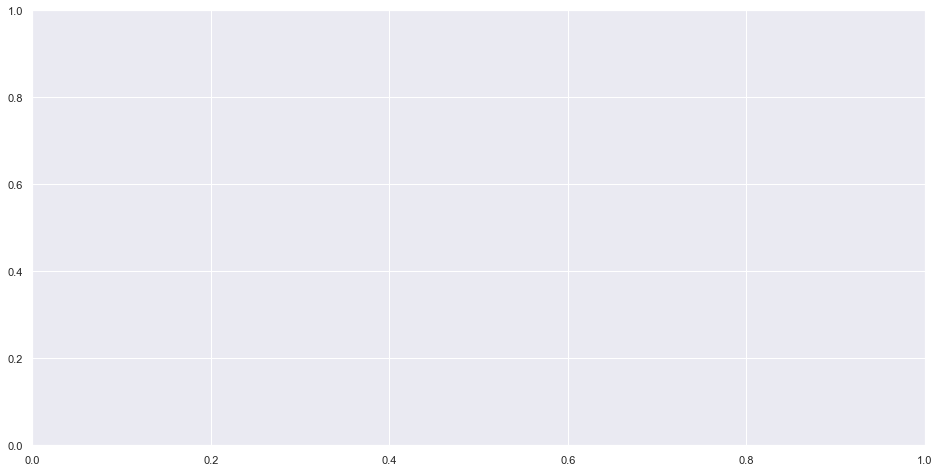

In [12]:
eigs,_=eigh(H)
print(eigs)
time=[t for t in range(200)]
plt.plot(time,energies_sv,'k--',label="sv")
plt.plot(time,energies_qasm,'b^',label="qasm, merge_step=1")
plt.plot(time,energies_no_merge,'r^',label="qasm, merge_step=None")
plt.legend(prop={'size': 20})

In [4]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 10,
    'delta_time' : 0.01,
    'merge_step' : 1,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'device_name':'ibmq_vigo',
    'mitigate_meas_error' : True,
    'qlanczos':True,
    'number_circuit_folds': 0,
    'number_cnot_pairs': 0
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(parameters['Nmax'],J=1,interaction=parameters["interaction"])
H_qubit = GrayCodeHamiltonian(H)      

energies_sv,coefs_sv=qite_experiment(H_qubit,parameters)
parameters['backend']='qasm_simulator'
energies_qasm,coefs_qasm=qite_experiment(H_qubit,parameters)

parameters['number_cnot_pairs']=5
parameters['backend']='qasm_simulator'
energies_qasm_extrap,coefs_qasm_extrap=qite_experiment(H_qubit,parameters)

# parameters['merge_step']=None
# energies_qasm_no_merge,coefs_qasm_nm=qite_experiment(H_qubit,parameters)

  0%|          | 0/10 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl
Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/10 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl
[0.2558, 0.2487, 0.2565, 0.2628, 0.2532, 0.2541]
extrapolated value  0.25421476190476194
[0.2465, 0.2581, 0.2548, 0.249, 0.2569, 0.2511]
extrapolated value  0.25156761904761915
[0.2552, 0.252, 0.2381, 0.2407, 0.2457, 0.2457]
extrapolated value  0.2517019047619047
[0.2425, 0.2412, 0.2506, 0.2475, 0.2442, 0.2491]
extrapolated value  0.2425157142857143
[0.2602, 0.2637, 0.2543, 0.2493, 0.2551, 0.2493]
extrapolated value  0.2626280952380952
[0.2492, 0.2515, 0.2486, 0.2585, 0.2462, 0.2589]
extrapolated value  0.24850714285714293
[0.2442, 0.2394, 0.2471, 0.2426, 0.2468, 0.249]
extrapolated value  0.24127571428571423
[0.2464, 0.2454, 0.25, 0.2496, 0.2519, 0.2428]
extrapolated value  0.24758904761904765
[0.5022, 0.5006, 0.5013, 0.4967, 0.4991, 0.5017]
extrapolated value  0.5012609523809526
[0.0047, 0.006, 0.0054, 0.0058, 0.0054, 0.0059]
extrapolated value  0.005139047619047621
[0.4879, 0.4879, 0.4881,

 10%|█         | 1/10 [00:02<00:23,  2.63s/it]

[0.9855, 0.987, 0.9826, 0.9842, 0.9847, 0.9853]
extrapolated value  0.9854233333333334
[0.0094, 0.0082, 0.0109, 0.0102, 0.0097, 0.01]
extrapolated value  0.009150476190476192
[0.005, 0.0046, 0.0064, 0.0054, 0.0056, 0.0044]
extrapolated value  0.005319047619047621
[0.0001, 0.0002, 0.0001, 0.0002, 0.0, 0.0003]
extrapolated value  0.00010714285714285716
[0.2729, 0.2677, 0.2726, 0.28, 0.2825, 0.2843]
extrapolated value  0.2673409523809524
[0.2311, 0.2435, 0.2442, 0.242, 0.2465, 0.2483]
extrapolated value  0.23464571428571432
[0.2686, 0.2604, 0.2566, 0.2558, 0.2494, 0.2499]
extrapolated value  0.26769476190476194
[0.2274, 0.2284, 0.2266, 0.2222, 0.2216, 0.2175]
extrapolated value  0.23031857142857154
[0.2579, 0.2639, 0.279, 0.2847, 0.2936, 0.2953]
extrapolated value  0.25491238095238106
[0.2531, 0.2433, 0.241, 0.2386, 0.2344, 0.23]
extrapolated value  0.25246095238095234
[0.2437, 0.2492, 0.2485, 0.25, 0.2548, 0.2515]
extrapolated value  0.24470523809523817
[0.2453, 0.2436, 0.2315, 0.2267, 0

 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

[0.8944, 0.7837, 0.699, 0.6288, 0.5766, 0.5341]
extrapolated value  0.8997857142857143
[0.0747, 0.1555, 0.2195, 0.2681, 0.2953, 0.3225]
extrapolated value  0.07628571428571444
[0.0231, 0.0407, 0.0515, 0.0635, 0.0725, 0.0798]
extrapolated value  0.021677619047619088
[0.0078, 0.0201, 0.03, 0.0396, 0.0556, 0.0636]
extrapolated value  0.002250952380952407
[0.2893, 0.2859, 0.288, 0.2779, 0.2882, 0.2894]
extrapolated value  0.2866814285714286
[0.216, 0.2321, 0.2416, 0.2475, 0.2473, 0.2473]
extrapolated value  0.22080476190476206
[0.2779, 0.2753, 0.2571, 0.262, 0.2528, 0.2477]
extrapolated value  0.2804419047619047
[0.2168, 0.2067, 0.2133, 0.2126, 0.2117, 0.2156]
extrapolated value  0.2120719047619047
[0.2583, 0.2769, 0.2811, 0.2902, 0.295, 0.3002]
extrapolated value  0.2602252380952382
[0.2448, 0.2514, 0.2457, 0.232, 0.2367, 0.2327]
extrapolated value  0.25068999999999997
[0.2508, 0.242, 0.2429, 0.2529, 0.2463, 0.2457]
extrapolated value  0.24698952380952388
[0.2461, 0.2297, 0.2303, 0.2249, 

 30%|███       | 3/10 [00:09<00:21,  3.00s/it]

[0.8935, 0.7754, 0.6955, 0.6325, 0.5804, 0.5286]
extrapolated value  0.8962452380952383
[0.0764, 0.1676, 0.2226, 0.2643, 0.2975, 0.3201]
extrapolated value  0.08333000000000013
[0.0215, 0.0355, 0.0491, 0.0597, 0.0684, 0.083]
extrapolated value  0.0171409523809524
[0.0086, 0.0215, 0.0328, 0.0435, 0.0537, 0.0683]
extrapolated value  0.0032838095238095556
[0.3028, 0.2994, 0.2895, 0.2935, 0.2959, 0.2949]
extrapolated value  0.29994285714285707
[0.2086, 0.2202, 0.2318, 0.238, 0.2452, 0.2422]
extrapolated value  0.20964000000000005
[0.2821, 0.2754, 0.2682, 0.2573, 0.2485, 0.2532]
extrapolated value  0.2843538095238095
[0.2065, 0.205, 0.2105, 0.2112, 0.2104, 0.2097]
extrapolated value  0.2060633333333333
[0.2524, 0.2703, 0.2747, 0.2879, 0.3025, 0.3049]
extrapolated value  0.2502052380952382
[0.2518, 0.2519, 0.2489, 0.2446, 0.2359, 0.2315]
extrapolated value  0.25728285714285715
[0.2537, 0.2443, 0.2489, 0.2436, 0.2448, 0.2472]
extrapolated value  0.2501947619047619
[0.2421, 0.2335, 0.2275, 0.2

 40%|████      | 4/10 [00:12<00:18,  3.03s/it]

[0.8862, 0.7809, 0.6943, 0.6296, 0.5656, 0.534]
extrapolated value  0.8936180952380953
[0.0811, 0.1614, 0.2188, 0.2682, 0.3049, 0.3146]
extrapolated value  0.08362761904761912
[0.022, 0.0368, 0.0535, 0.058, 0.073, 0.0822]
extrapolated value  0.018755714285714334
[0.0107, 0.0209, 0.0334, 0.0442, 0.0565, 0.0692]
extrapolated value  0.003998571428571468
[0.3197, 0.3068, 0.3034, 0.3104, 0.2987, 0.3012]
extrapolated value  0.31611142857142865
[0.1998, 0.2149, 0.224, 0.2288, 0.2442, 0.2531]
extrapolated value  0.19667809523809535
[0.2816, 0.2761, 0.2657, 0.2593, 0.2542, 0.2387]
extrapolated value  0.28716571428571436
[0.1989, 0.2022, 0.2069, 0.2015, 0.2029, 0.207]
extrapolated value  0.2000447619047619
[0.2508, 0.2754, 0.2946, 0.2926, 0.3006, 0.3063]
extrapolated value  0.256622380952381
[0.258, 0.2436, 0.2466, 0.247, 0.2427, 0.2395]
extrapolated value  0.25435904761904776
[0.2475, 0.248, 0.2409, 0.2447, 0.236, 0.2382]
extrapolated value  0.2492957142857143
[0.2437, 0.233, 0.2179, 0.2157, 0.

 50%|█████     | 5/10 [00:15<00:15,  3.04s/it]

[0.8845, 0.7772, 0.6952, 0.6272, 0.5785, 0.5327]
extrapolated value  0.8902442857142858
[0.0844, 0.1683, 0.2233, 0.2633, 0.2949, 0.3091]
extrapolated value  0.0916004761904763
[0.0218, 0.0352, 0.0468, 0.0597, 0.0672, 0.0844]
extrapolated value  0.01635380952380958
[0.0093, 0.0193, 0.0347, 0.0498, 0.0594, 0.0738]
extrapolated value  0.001801428571428608
[0.3264, 0.3157, 0.3126, 0.3064, 0.3061, 0.3047]
extrapolated value  0.3242833333333334
[0.1836, 0.2074, 0.2208, 0.2355, 0.2442, 0.2517]
extrapolated value  0.1839580952380953
[0.2954, 0.2821, 0.2756, 0.2566, 0.2517, 0.2418]
extrapolated value  0.2996171428571428
[0.1946, 0.1948, 0.191, 0.2015, 0.198, 0.2018]
extrapolated value  0.1921414285714286
[0.2711, 0.2781, 0.2788, 0.298, 0.3071, 0.3163]
extrapolated value  0.263092380952381
[0.2519, 0.2506, 0.2573, 0.2428, 0.2455, 0.2445]
extrapolated value  0.25449238095238097
[0.2396, 0.2386, 0.2372, 0.2403, 0.2298, 0.2242]
extrapolated value  0.2435471428571429
[0.2374, 0.2327, 0.2267, 0.2189,

 60%|██████    | 6/10 [00:18<00:12,  3.17s/it]

[0.8787, 0.7691, 0.6826, 0.6172, 0.57, 0.5245]
extrapolated value  0.8822861904761906
[0.0864, 0.1685, 0.2285, 0.2692, 0.2957, 0.316]
extrapolated value  0.09278619047619062
[0.0246, 0.0382, 0.0509, 0.0633, 0.0742, 0.0865]
extrapolated value  0.01943476190476195
[0.0103, 0.0242, 0.038, 0.0503, 0.0601, 0.073]
extrapolated value  0.005492857142857165
[0.341, 0.3285, 0.3195, 0.313, 0.3053, 0.3179]
extrapolated value  0.3372895238095239
[0.1831, 0.1995, 0.2174, 0.2277, 0.2472, 0.2517]
extrapolated value  0.1785514285714287
[0.286, 0.279, 0.271, 0.2662, 0.2628, 0.2374]
extrapolated value  0.29247238095238104
[0.1899, 0.193, 0.1921, 0.1931, 0.1847, 0.193]
extrapolated value  0.19168666666666667
[0.2649, 0.2854, 0.2946, 0.3034, 0.3092, 0.3168]
extrapolated value  0.26659952380952373
[0.2439, 0.248, 0.2426, 0.2516, 0.2518, 0.2486]
extrapolated value  0.24398714285714285
[0.247, 0.2427, 0.238, 0.2289, 0.2339, 0.2263]
extrapolated value  0.24804761904761904
[0.2442, 0.2239, 0.2248, 0.2161, 0.205

 70%|███████   | 7/10 [00:22<00:09,  3.25s/it]

[0.8724, 0.761, 0.6845, 0.621, 0.5614, 0.521]
extrapolated value  0.877585238095238
[0.0903, 0.1731, 0.2278, 0.2564, 0.2949, 0.3149]
extrapolated value  0.09620476190476199
[0.0253, 0.0388, 0.0482, 0.0668, 0.0761, 0.0838]
extrapolated value  0.020242857142857198
[0.012, 0.0271, 0.0395, 0.0558, 0.0676, 0.0803]
extrapolated value  0.0059671428571429095
[0.3455, 0.3408, 0.322, 0.3163, 0.321, 0.3178]
extrapolated value  0.344684761904762
[0.17, 0.1993, 0.2141, 0.2357, 0.239, 0.2487]
extrapolated value  0.17201142857142865
[0.312, 0.2794, 0.2763, 0.268, 0.2524, 0.2441]
extrapolated value  0.30878761904761914
[0.1725, 0.1805, 0.1876, 0.18, 0.1876, 0.1894]
extrapolated value  0.17451619047619046
[0.2599, 0.284, 0.2892, 0.3082, 0.3121, 0.3175]
extrapolated value  0.2616100000000001
[0.2591, 0.2508, 0.2532, 0.2426, 0.2463, 0.2385]
extrapolated value  0.2593109523809524
[0.2501, 0.2359, 0.2338, 0.2358, 0.2333, 0.229]
extrapolated value  0.2458566666666667
[0.2309, 0.2293, 0.2238, 0.2134, 0.2083,

 80%|████████  | 8/10 [00:25<00:06,  3.25s/it]

[0.868, 0.7654, 0.6794, 0.6156, 0.5569, 0.5185]
extrapolated value  0.8761685714285713
[0.0945, 0.1712, 0.2283, 0.265, 0.2922, 0.3171]
extrapolated value  0.09839000000000019
[0.0239, 0.0352, 0.0475, 0.0646, 0.0758, 0.089]
extrapolated value  0.016194285714285765
[0.0136, 0.0282, 0.0448, 0.0548, 0.0751, 0.0754]
extrapolated value  0.009247142857142898
[0.3592, 0.3421, 0.3452, 0.3246, 0.3257, 0.3254]
extrapolated value  0.35750190476190485
[0.1678, 0.1868, 0.21, 0.2327, 0.2448, 0.2429]
extrapolated value  0.16512095238095248
[0.2934, 0.2899, 0.2599, 0.2656, 0.2429, 0.2458]
extrapolated value  0.29824714285714293
[0.1796, 0.1812, 0.1849, 0.1771, 0.1866, 0.1859]
extrapolated value  0.17913000000000012
[0.2675, 0.285, 0.2959, 0.3095, 0.3127, 0.3166]
extrapolated value  0.2685352380952382
[0.2449, 0.2542, 0.2524, 0.2554, 0.2516, 0.2533]
extrapolated value  0.24877809523809533
[0.2489, 0.235, 0.233, 0.2304, 0.2249, 0.2275]
extrapolated value  0.24527476190476175
[0.2387, 0.2258, 0.2187, 0.20

 90%|█████████ | 9/10 [00:29<00:03,  3.33s/it]

[0.8643, 0.7639, 0.6732, 0.6158, 0.5659, 0.5184]
extrapolated value  0.8709938095238097
[0.0998, 0.17, 0.2295, 0.2611, 0.288, 0.3064]
extrapolated value  0.10420571428571442
[0.0214, 0.0344, 0.051, 0.0669, 0.074, 0.0931]
extrapolated value  0.014525714285714307
[0.0145, 0.0317, 0.0463, 0.0562, 0.0721, 0.0821]
extrapolated value  0.01027476190476195
[0.3651, 0.3442, 0.3332, 0.3298, 0.3214, 0.315]
extrapolated value  0.36240904761904763
[0.154, 0.1859, 0.2168, 0.2321, 0.2448, 0.2563]
extrapolated value  0.1546833333333334
[0.3032, 0.2919, 0.2693, 0.2619, 0.2536, 0.2482]
extrapolated value  0.3054042857142858
[0.1777, 0.178, 0.1807, 0.1762, 0.1802, 0.1805]
extrapolated value  0.17750333333333337
[0.2731, 0.2886, 0.2976, 0.3043, 0.3193, 0.3237]
extrapolated value  0.2709457142857144
[0.2496, 0.251, 0.2497, 0.2547, 0.2472, 0.2514]
extrapolated value  0.25037714285714285
[0.2431, 0.2354, 0.234, 0.2252, 0.2239, 0.2145]
extrapolated value  0.24531857142857152
[0.2342, 0.225, 0.2187, 0.2158, 0.

100%|██████████| 10/10 [00:32<00:00,  3.27s/it]

[0.8638, 0.7564, 0.6729, 0.6136, 0.5637, 0.5084]
extrapolated value  0.8700819047619045
[0.1029, 0.1713, 0.2283, 0.2616, 0.2859, 0.3089]
extrapolated value  0.10587476190476199
[0.0194, 0.0356, 0.0489, 0.0689, 0.0764, 0.0882]
extrapolated value  0.014541904761904789
[0.0139, 0.0367, 0.0499, 0.0559, 0.074, 0.0945]
extrapolated value  0.009501428571428615


[-2.0456709   8.56158173 24.54750806]


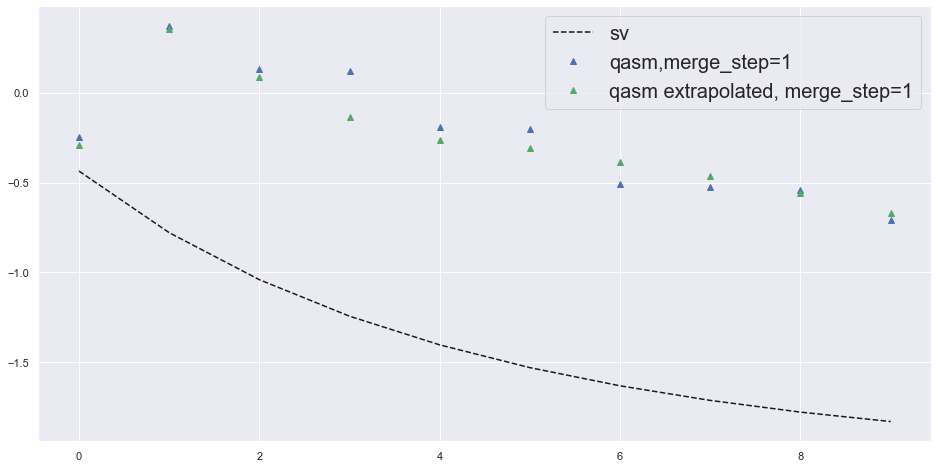

In [5]:
eigs,_=eigh(H)
print(eigs)
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,energies_sv,'k--',label="sv")
plt.plot(time,energies_qasm,'b^',label="qasm,merge_step=1")
plt.plot(time,energies_qasm_extrap,'g^',label="qasm extrapolated, merge_step=1")
# plt.plot(time,energies_qasm_no_merge,'r^',label="qasm, merge_step=None")
plt.legend(prop={'size': 20})

In [ ]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'jordan_wigner',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 150,
    'delta_time' : 0.01,
    'merge_step' : 1,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'device_name':'ibmq_vigo',
    'mitigate_meas_error' : True,
    'qlanczos':True
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(parameters['Nmax'],J=1,interaction=parameters["interaction"])
H_qubit = JordanWignerHamiltonian(H)      

energies_sv,coefs_sv=qite_experiment(H_qubit,parameters)
parameters['backend']='qasm_simulator'
energies_qasm,coefs_qasm=qite_experiment(H_qubit,parameters)

parameters['merge_step']=None
energies_no_merge,coefs_no_merge=qite_experiment(H_qubit,parameters)


  3%|▎         | 5/150 [00:00<00:03, 43.06it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


  0%|          | 0/150 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


  0%|          | 0/150 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


 33%|███▎      | 50/150 [24:17<1:25:06, 51.06s/it]

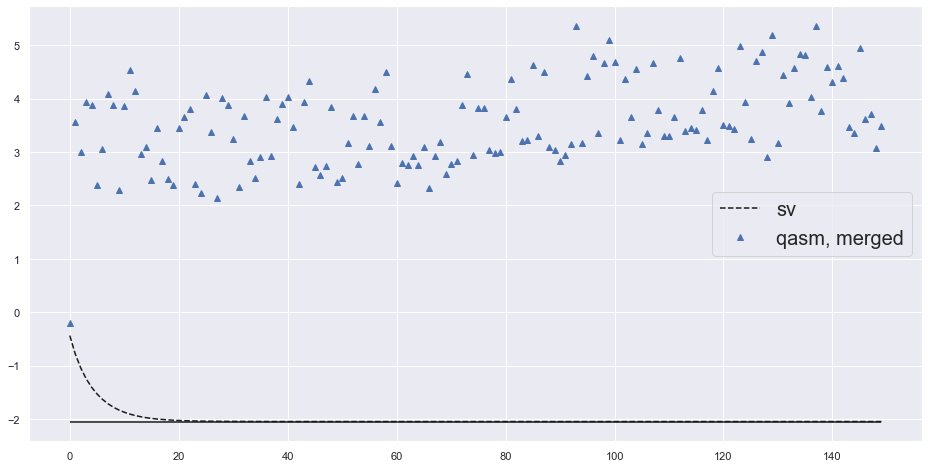

In [35]:
eigs,_=eigh(H)
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,energies_sv,'k--',label="sv")
plt.plot(time,energies_qasm,'b^',label="qasm, merged")
# plt.plot(time,energies_no_merge,'r^',label="qasm")
plt.hlines(eigs[0],0,parameters['N_time_steps']-1)
plt.legend(prop={'size': 20})

In [7]:
circuit.num_qubits

2

In [4]:
a=[1.,2.,3.,4.]


TypeError: unsupported operand type(s) for /: 'list' and 'int'